# brain_Linear_XGboost_Lasso_Ridge_modeling -55
DC

#### This notebook:
* Load the EWAS aging data selecting for whole blood data and the 2259n ranked cpgs by XGboost importance
* Fit Linear Regression, XGboost, Lasso, and Ridge models predicting age using the  55 cpgs
* Test models on Test data
* Save models



#### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import os
import pickle
import warnings
warnings.simplefilter('ignore')
plt.rcdefaults()

#### Import our modules

In [2]:
import age_predict.Loading_EWAS_Aging_Data as le
import age_predict.Regression as rg
import age_predict.Pickle_unpickle as pu

In [3]:
# View working directory
os.getcwd()

'/Users/dcox/Desktop/EWAS-organized/brain/modeling_linear_XGboost'

In [4]:
data_path = '../feature_selection/'
cpg_path = '../saved_features/'
save_models_path = '../saved_models/'
save_blood_model_path = '../../blood/saved_models/'

#### Get Saved imputed brain data 2259 cpgs

In [5]:
df_train = pd.read_csv(data_path + 'df_p_working_brain_ranked.csv', index_col=0)
df_test = pd.read_csv(data_path +  'df_p_saved_brain_ranked.csv', index_col=0)

#### Get Saved brain cpg rankings

In [6]:
cpgs_XGboost_brain_ranked = pu.get_pickled_object(cpg_path + 'cpgs_XGboost_brain_ranked')

In [7]:
top_100 = cpgs_XGboost_brain_ranked[:100]
top_1000 = cpgs_XGboost_brain_ranked[:1000]

#### Histograms of Age

In [8]:
s = pd.Series(list(df_train.age) + list(df_test.age))

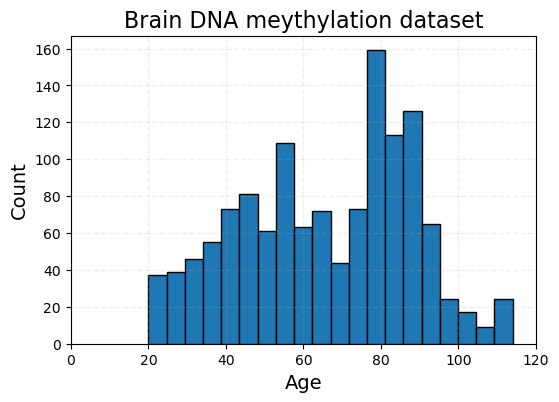

In [9]:
# Histogram of ages in train plus test data
plt.figure(figsize=(6,4))
s.hist(bins=20,histtype='bar', ec='black' )
plt.xlabel('Age', fontsize=14)
plt.xlim(0,120)
plt.ylabel('Count', fontsize=14)
plt.grid(True, lw=1, ls = '--', alpha=0.2)
plt.title('Brain DNA meythylation dataset', fontsize=16)
plt.show()

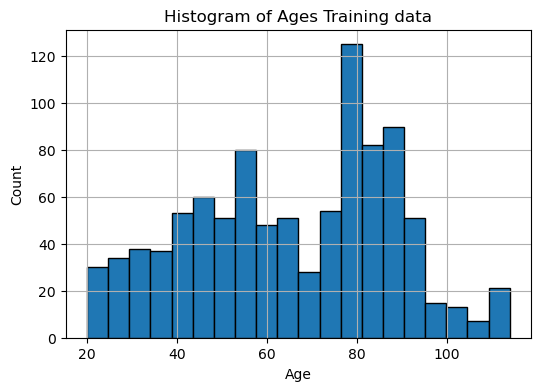

In [10]:
# Histogram of ages in train data
plt.figure(figsize=(6,4))
df_train.age.hist(bins=20, histtype='bar', ec='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages Training data')
plt.show()

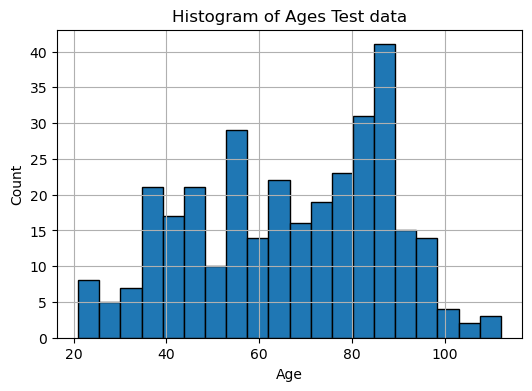

In [11]:
# Histogram of ages in test data
plt.figure(figsize=(6,4))
df_test.age.hist(bins=20,histtype='bar', ec='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages Test data')
plt.show()

### Looking at data

In [12]:
df_train

,tissue,age,cg18514820,cg21182694,cg09784307,cg01066472,cg02426178,cg12373771,cg16367511,cg24369989,cg23352942,cg04845871,cg11236550,cg15731815,cg17104258,cg18008766,cg24853724,cg11018337,cg15341124,cg15393490,cg14266527,cg27529628,cg21860429,cg06022942,cg03314644,cg26118408,cg00303378,cg01122755,cg07907745,cg03013329,cg17117277,cg19622662,cg02746869,cg14919554,cg11705975,cg26242531,cg06993413,cg23606718,cg13806070,cg04880546,cg13327545,cg01504656,cg03127563,cg00807959,cg12765028,cg17801546,cg22866825,cg04739123,cg19451698,cg04834794,...,cg15387132,cg27642771,cg08090496,cg17892680,cg16895493,cg09430689,cg00687252,cg13271228,cg11073104,cg19442201,cg22045340,cg00521255,cg12113984,cg00718791,cg11912306,cg04297522,cg23444264,cg00765705,cg12603338,cg22663872,cg08378356,cg23880794,cg23156348,cg08059859,cg13154925,cg13964746,cg23058911,cg00593900,cg19401519,cg12175729,cg06043159,cg27446671,cg15317927,cg03189756,cg22068629,cg19939503,cg09982005,cg22830707,cg09563311,cg01302668,cg00306510,cg06094111,cg13427827,cg00927554,cg26122710,cg11366934,cg08512847,cg08761997,cg24189904,cg12505230
GSM2139432,brain - superior temporal gyrus,71,0.075,0.240,0.244,0.331,0.543,0.188,0.217,0.509000,0.475,0.067,0.106,0.139,0.106,0.105,0.090,0.144,0.212,0.226,0.343,0.144,0.132,0.185,0.125,0.059,0.835,0.107,0.235,0.124,0.261,0.088,0.087,0.172,0.391,0.263,0.087,0.158,0.128,0.393,0.299,0.087000,0.014,0.288,0.246,0.157,0.088,0.037,0.102,0.124,...,0.019,0.051,0.578,0.625,0.928,0.026,0.214,0.201,0.982,0.236,0.047,0.082,0.050,0.019,0.014,0.479,0.707,0.176,0.005,0.155,0.005,0.020,0.039,0.673,0.607,0.984,0.709,0.017,0.830,0.080,0.267,0.952,0.067000,0.011,0.801,0.849,0.041,0.189,0.766,0.757,0.888,0.018,0.902,0.161,0.718,0.352,0.910,0.013,0.053,0.979
GSM2139249,brain - superior temporal gyrus,76,0.061,0.215,0.269,0.378,0.526,0.165,0.161,0.463000,0.466,0.071,0.087,0.124,0.101,0.130,0.126,0.135,0.254,0.235,0.377,0.151,0.120,0.215,0.172,0.072,0.773,0.100,0.201,0.085,0.291,0.095,0.094,0.163,0.438,0.205,0.123,0.153,0.140,0.393,0.368,0.100000,0.013,0.329,0.278,0.162,0.157,0.039,0.064,0.084,...,0.018,0.054,0.465,0.706,0.961,0.035,0.220,0.165,0.981,0.307,0.040,0.049,0.034,0.020,0.029,0.567,0.762,0.207,0.004,0.235,0.005,0.022,0.028,0.649,0.647,0.986,0.671,0.016,0.832,0.045,0.264,0.963,0.403000,0.018,0.737,0.869,0.046,0.196,0.748,0.816,0.886,0.023,0.827,0.095,0.724,0.385,0.880,0.016,0.042,0.970
GSM2139398,brain - superior temporal gyrus,102,0.060,0.219,0.227,0.339,0.480,0.171,0.124,0.523000,0.432,0.039,0.198,0.171,0.188,0.114,0.093,0.122,0.279,0.181,0.376,0.104,0.104,0.156,0.134,0.067,0.797,0.075,0.221,0.097,0.262,0.154,0.091,0.116,0.407,0.224,0.084,0.121,0.067,0.389,0.377,0.071000,0.014,0.294,0.284,0.207,0.163,0.044,0.085,0.063,...,0.016,0.039,0.507,0.584,0.904,0.032,0.193,0.206,0.987,0.288,0.070,0.055,0.032,0.013,0.049,0.608,0.724,0.092,0.002,0.154,0.004,0.018,0.022,0.690,0.623,0.978,0.671,0.026,0.851,0.043,0.211,0.953,0.391000,0.013,0.734,0.853,0.041,0.225,0.778,0.779,0.847,0.021,0.873,0.083,0.701,0.347,0.885,0.017,0.060,0.969
GSM2139297,brain - superior temporal gyrus,108,0.147,0.293,0.362,0.528,0.514,0.286,0.261,0.602000,0.559,0.020,0.057,0.189,0.054,0.168,0.146,0.273,0.309,0.147,0.497,0.199,0.185,0.325,0.226,0.088,0.860,0.222,0.322,0.132,0.319,0.053,0.149,0.228,0.454,0.173,0.137,0.262,0.153,0.436,0.370,0.073117,0.009,0.327,0.339,0.111,0.121,0.088,0.105,0.192,...,0.017,0.074,0.677,0.722,0.907,0.032,0.286,0.195,0.978,0.381,0.062,0.081,0.035,0.026,0.021,0.681,0.768,0.104,0.002,0.274,0.004,0.013,0.048,0.712,0.727,0.982,0.628,0.022,0.832,0.064,0.269,0.979,0.426000,0.000,0.805,0.841,0.039,0.220,0.736,0.809,0.922,0.021,0.885,0.153,0.784,0.372,0.896,0.013,0.087,0.981
GSM1069208,brain - superior temporal gyrus,40,0.061,0.193,0.195,0.452,0.621,0.124,0.083,0.441000,0.602,0.032,0.314,0.057,0.250,0.073,0.072,0.106,0.188,0.271,0.282,0.125,0.093,0.134,0.054,0.025,0.706,0.059,0.193,0.029,0.143,0.232,0.083,0.111,0.303,0.264,0.065,0.085,0.056,0.289,0.185,0.070000,0.028,0.152,0.204,0.338,

In [13]:
df_test

,tissue,age,cg18514820,cg21182694,cg09784307,cg01066472,cg02426178,cg12373771,cg16367511,cg24369989,cg23352942,cg04845871,cg11236550,cg15731815,cg17104258,cg18008766,cg24853724,cg11018337,cg15341124,cg15393490,cg14266527,cg27529628,cg21860429,cg06022942,cg03314644,cg26118408,cg00303378,cg01122755,cg07907745,cg03013329,cg17117277,cg19622662,cg02746869,cg14919554,cg11705975,cg26242531,cg06993413,cg23606718,cg13806070,cg04880546,cg13327545,cg01504656,cg03127563,cg00807959,cg12765028,cg17801546,cg22866825,cg04739123,cg19451698,cg04834794,...,cg15387132,cg27642771,cg08090496,cg17892680,cg16895493,cg09430689,cg00687252,cg13271228,cg11073104,cg19442201,cg22045340,cg00521255,cg12113984,cg00718791,cg11912306,cg04297522,cg23444264,cg00765705,cg12603338,cg22663872,cg08378356,cg23880794,cg23156348,cg08059859,cg13154925,cg13964746,cg23058911,cg00593900,cg19401519,cg12175729,cg06043159,cg27446671,cg15317927,cg03189756,cg22068629,cg19939503,cg09982005,cg22830707,cg09563311,cg01302668,cg00306510,cg06094111,cg13427827,cg00927554,cg26122710,cg11366934,cg08512847,cg08761997,cg24189904,cg12505230
GSM1443263,brain - frontal cortex,81,0.076,0.344,0.282,0.416,0.538,0.182,0.182000,0.486,0.534,0.046,0.127,0.193,0.047,0.140,0.114,0.143,0.261,0.214,0.427,0.168,0.127,0.251,0.203,0.091,0.718,0.160,0.242,0.17600,0.279,0.083,0.103,0.155,0.477,0.081,0.123,0.233,0.150,0.435,0.338,0.114000,0.009,0.345,0.282,0.134,0.208,0.034,0.121,0.101,...,0.032,0.048,0.492,0.630,0.925,0.021,0.191,0.226,0.978000,0.201,0.053,0.079,0.026,0.023,0.041,0.619,0.723,0.165,0.005,0.135,0.003,0.018,0.043000,0.688,0.692,0.983,0.684,0.029,0.814,0.029,0.232,0.946,0.413,0.011,0.786,0.882,0.046,0.196,0.860,0.798,0.915,0.021,0.892,0.059000,0.810,0.406,0.853,0.018,0.058,0.981
GSM1438273,brain - occipital lobe,65,0.161,0.172,0.110,0.364,0.592,0.110,0.134000,0.395,0.593,0.074,0.288,0.046,0.303,0.044,0.021,0.125,0.185,0.232,0.352,0.120,0.071,0.171,0.057,0.044,0.865,0.071,0.172,0.06100,0.171,0.297,0.106,0.138,0.332,0.211,0.063,0.153,0.127,0.264,0.262,0.080000,0.015,0.222,0.240,0.359,0.058,0.044,0.032,0.025,...,0.017,0.030,0.713,0.699,0.950,0.022,0.168,0.106,0.973000,0.400,0.066,0.046,0.220,0.013,0.042,0.469,0.753,0.164,0.003,0.105,0.023,0.016,0.013000,0.699,0.814,0.977,0.592,0.011,0.894,0.023,0.257,0.977,0.068,0.030,0.891,0.898,0.055,0.137,0.834,0.782,0.839,0.014,0.853,0.084000,0.759,0.383,0.906,0.021,0.044,0.993
GSM1069394,brain - frontal lobe,79,0.096,0.249,0.288,0.248,0.489,0.246,0.169000,0.596,0.517,0.037,0.065,0.164,0.050,0.179,0.108,0.140,0.269,0.205,0.434,0.202,0.103,0.198,0.173,0.093,0.788,0.121,0.222,0.06500,0.244,0.052,0.073,0.182,0.440,0.245,0.135,0.218,0.159,0.404,0.363,0.105000,0.006,0.276,0.321,0.122,0.166,0.084,0.143,0.110,...,0.021,0.068,0.648,0.693,0.909,0.030,0.331,0.256,0.984000,0.293,0.056,0.068,0.031,0.030,0.030,0.572,0.752,0.153,0.005,0.242,0.006,0.016,0.045000,0.687,0.738,0.990,0.692,0.044,0.868,0.069,0.276,0.950,0.096,0.010,0.748,0.843,0.058,0.215,0.783,0.804,0.901,0.022,0.886,0.109000,0.774,0.395,0.886,0.016,0.051,0.933
GSM1069008,brain - frontal lobe,85,0.108,0.294,0.261,0.574,0.506,0.228,0.180000,0.546,0.479,0.058,0.064,0.152,0.086,0.132,0.104,0.182,0.280,0.234,0.427,0.175,0.177,0.217,0.197,0.074,0.892,0.139,0.237,0.11200,0.278,0.065,0.125,0.188,0.411,0.100,0.100,0.184,0.146,0.379,0.301,0.071000,0.014,0.301,0.276,0.094,0.097,0.035,0.164,0.091,...,0.040,0.055,0.617,0.688,0.936,0.020,0.232,0.239,0.988000,0.217,0.052,0.045,0.043,0.018,0.031,0.731,0.745,0.152,0.003,0.206,0.006,0.014,0.057000,0.696,0.703,0.976,0.708,0.050,0.853,0.046,0.262,0.968,0.420,0.020,0.860,0.825,0.048,0.199,0.747,0.760,0.879,0.012,0.886,0.118000,0.758,0.368,0.854,0.011,0.060,0.960
GSM1069068,brain - entorhinal cortex,87,0.119,0.230,0.314,0.399,0.523,0.256,0.188000,0.528,0.566,0.057,0.175,0.194,0.188,0.153,0.114,0.156,0.312,0.333,0.425,0.129,0.153,0.219,0.102,0.134,0.814,0.195,0.254,0.09500,0.322,0.102,0.118,0.194,0.477,0.185,0.117,0.218,0.174,0.424,0.405,0.066000,0.021,0.349,0.356,0.206,0.180,0.069,0.

#### 1000 cpgs, Train models on training data 70/30 split, Linear, Ridge, Lasso and XGboost 

In [14]:
cpgs_55 = ['cg01066472', 'cg18514820', 'cg21182694', 'cg11236550', 'cg24369989', 'cg15731815', 'cg04845871', 'cg15341124', 'cg16367511', 'cg18008766', 'cg11018337', 'cg23352942', 'cg17104258', 'cg06022942', 'cg02746869', 'cg15393490', 'cg13327545', 'cg04739123', 'cg26118408', 'cg13806070', 'cg19622662', 'cg00807959', 'cg04834794', 'cg17179314', 'cg12765028', 'cg07907745', 'cg04897644', 'cg10533159', 'cg24079702', 'cg23091758', 'cg00927231', 'cg00303378', 'cg08715791', 'cg07303143', 'cg23606718', 'cg17117277', 'cg11823178', 'cg17801546', 'cg19451698', 'cg26102082', 'cg15907146', 'cg26830108', 'cg22454769', 'cg24668570', 'cg04347477', 'cg06829968', 'cg23595055', 'cg04098194', 'cg15463803', 'cg24441324', 'cg14911690', 'cg07227926', 'cg25090514', 'cg23995914', 'cg03169557']

In [15]:
from sklearn.model_selection import train_test_split
X = df_train[cpgs_55]
y = df_train.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

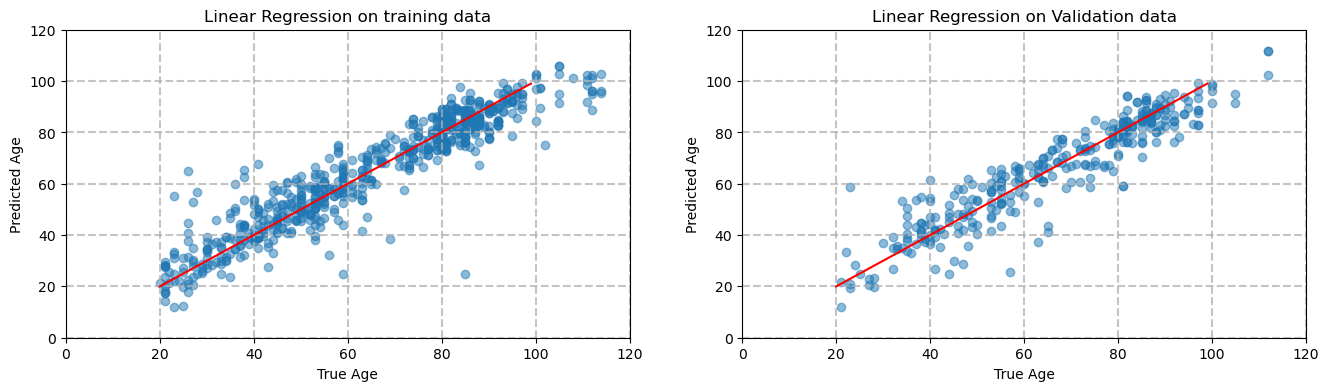

The rms on the training data is 7.772 years
The rms on the validation data is 7.680 years
The r^2 on the training data is 0.883
The r^2 on the validation data is 0.865
The MAe on the training data is 5.433 years
The MAE on the validation data is 5.586


In [25]:
brain_mod_55, rms_train, rms_test, r2_train, r2_test = rg.linear_regress(X_train, y_train, X_test, y_test, plot=True)

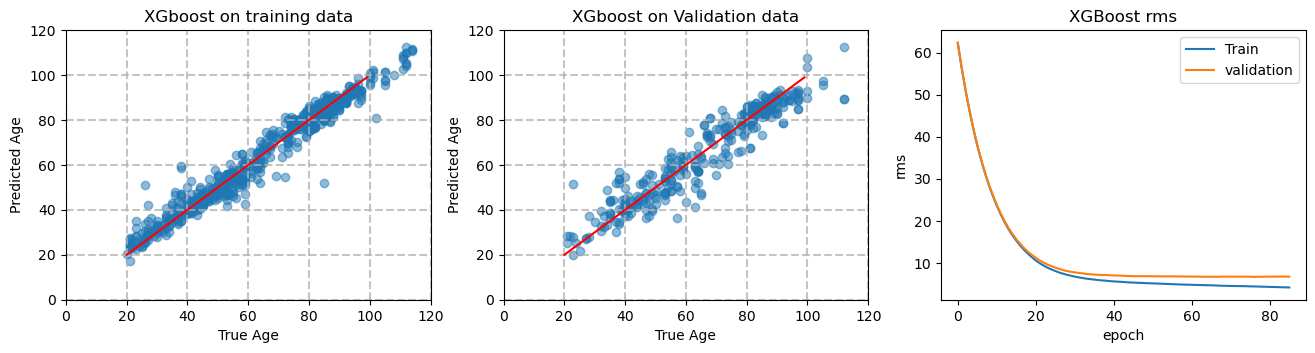

The number of training epochs was 86
The rms on the training data is 4.446 years
The rms on the validation data is 6.721 years
The r^2 on the training data is 0.962
The r^2 on the validation data is 0.897
The MAE on the training data is 3.130 years
The MAE on the validation data is 4.937 years


In [26]:
brain_mod_XG_55, rms_train, rms_test, r2_train, r2_test, feature_importances_ = rg.xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10)

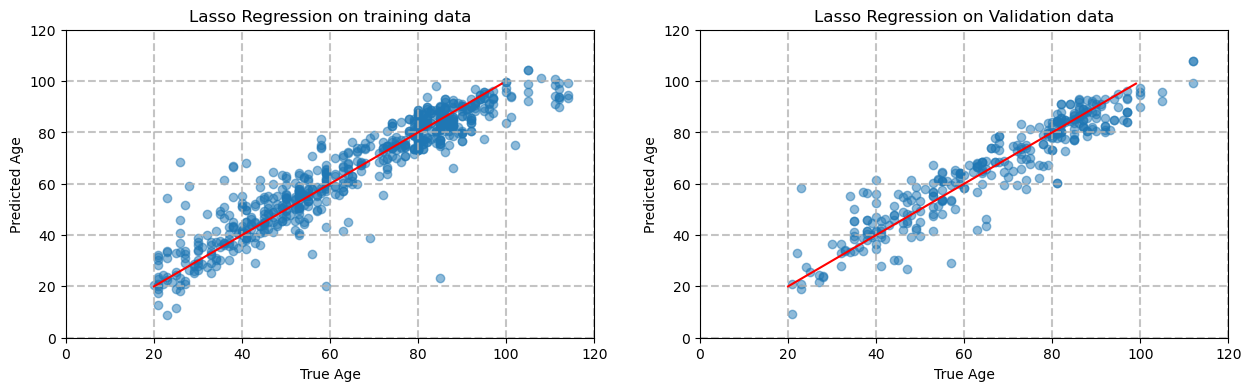

The rms on the training data is 7.982 years
The rms on the validation data is 7.367 years
The r^2 on the training data is 0.876
The r^2 on the validation data is 0.876
The MAE on the training data is 5.421 years
The MAE on the validation data is 5.422 years
Optimal alpha from CV = 0.01


In [27]:
brain_mod_lasso_55, rms_train, rms_test, r2_train, r2_test = rg.lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

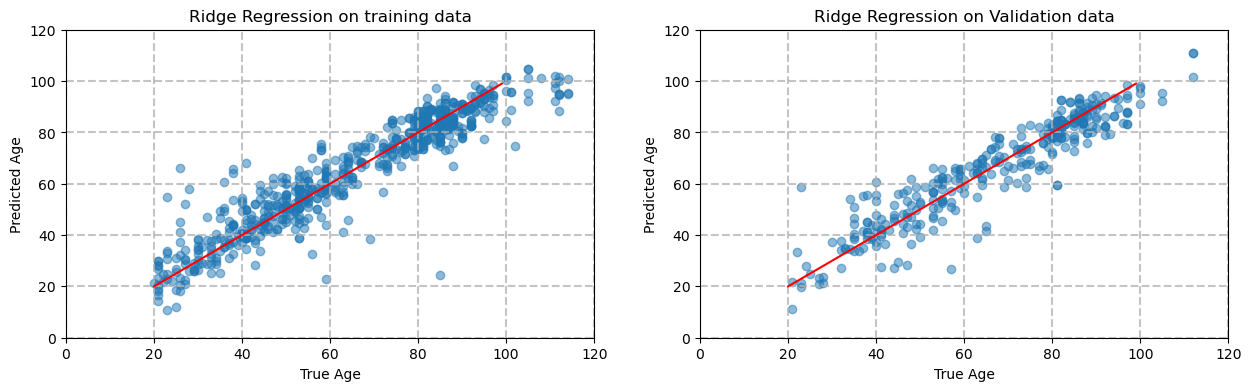

The rms on the training data is 7.809 years
The rms on the validation data is 7.557 years
The r^2 on the training data is 0.881
The r^2 on the validation data is 0.870
The MAE on the training data is 5.385 years
The MAE on the validation data is 5.537 years
Optimal alpha from CV = 0.1


In [28]:
brain_mod_ridge_55, rms_train, rms_test, r2_train, r2_test = rg.ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

### Saving models

In [29]:
#Save models
pu.pickle_object(brain_mod_55, save_models_path + 'brain_mod_55')
pu.pickle_object(brain_mod_ridge_55, save_models_path + 'brain_mod_ridge_55')
pu.pickle_object(brain_mod_lasso_55, save_models_path + 'brain_mod_lasso_55')
pu.pickle_object(brain_mod_XG_55, save_models_path + 'brain_mod_XG_55')

pickled as ../saved_models/brain_mod_55
pickled as ../saved_models/brain_mod_ridge_55
pickled as ../saved_models/brain_mod_lasso_55
pickled as ../saved_models/brain_mod_XG_55


##### 55 top cpgs, Testing models on held out test data

In [30]:
X_test = df_test[cpgs_55]
y_test = df_test.age

In [38]:
brain_mod_55 = pu.get_pickled_object(save_models_path + 'brain_mod_55')
brain_mod_ridge_55 = pu.get_pickled_object(save_models_path + 'brain_mod_ridge_55')
brain_mod_lasso_55 = pu.get_pickled_object(save_models_path + 'brain_mod_lasso_55')
brain_mod_XG_55 = pu.get_pickled_object(save_models_path + 'brain_mod_XG_55')

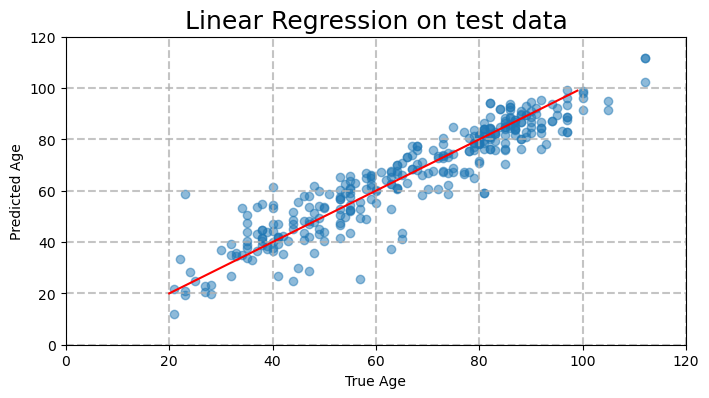

The MSE on Test data is 58.989 years
The rms on Test data is 7.680 years
The r^2 on Test data is 0.865
The mae on Test data is 5.586 years
The correlation on the Test data true-predicted is 0.931


In [39]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_55, mtype='Linear Regression', figsize=(8,4))

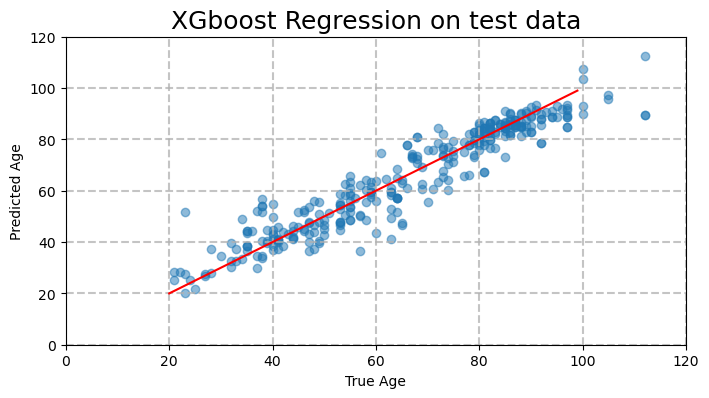

The MSE on Test data is 45.172 years
The rms on Test data is 6.721 years
The r^2 on Test data is 0.897
The mae on Test data is 4.937 years
The correlation on the Test data true-predicted is 0.947


In [40]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_XG_55, mtype='XGboost Regression', figsize=(8,4))

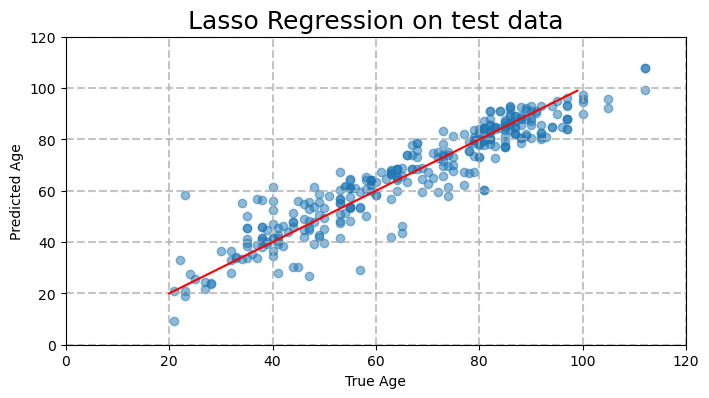

The MSE on Test data is 54.278 years
The rms on Test data is 7.367 years
The r^2 on Test data is 0.876
The mae on Test data is 5.422 years
The correlation on the Test data true-predicted is 0.936


In [41]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_lasso_55, mtype='Lasso Regression', figsize=(8,4))

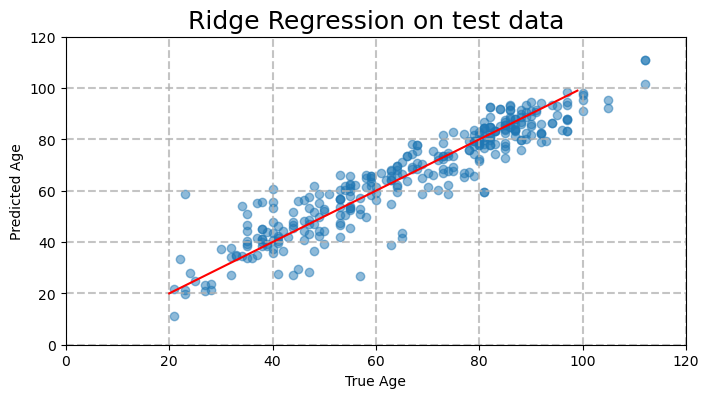

The MSE on Test data is 57.102 years
The rms on Test data is 7.557 years
The r^2 on Test data is 0.870
The mae on Test data is 5.537 years
The correlation on the Test data true-predicted is 0.933


In [42]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, brain_mod_ridge_55, mtype='Ridge Regression', figsize=(8,4))

In [60]:
wb_mod_ridge_1000 = pu.get_pickled_object(save_blood_model_path + 'wb_mod_ridge_1000')
wb_mod_ridge_100 = pu.get_pickled_object(save_blood_model_path + 'wb_mod_ridge_100')